In [46]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

import nltk.downloader
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from sklearn.utils import resample

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from pydataset import data
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, accuracy_score, log_loss, f1_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter("ignore")

### Loading the Data

In [2]:
#Loading both the test and the train data
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')

In [3]:
#Briefly view the data
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath ...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zoku...
2,eng,the province of kwazulu-natal department of transport invites tenders from established...
3,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a ...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinga...


In [4]:
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlelela kgato eo."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye imitlolo engezelelako ukuqedelela ukutl...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini naticocisana.
4,5,Winste op buitelandse valuta.


### Exploratory Data Analysis (EDA)

In [5]:
df_train.shape

(33000, 2)

In [6]:
df_test.shape

(5682, 2)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   5682 non-null   int64 
 1   text    5682 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.9+ KB


In [9]:
df_train.isnull().sum()

lang_id    0
text       0
dtype: int64

In [10]:
df_test.isnull().sum()

index    0
text     0
dtype: int64

In [11]:
#Checking for any duplicated values
df_train.duplicated().sum()

3052

In [12]:
df_test.duplicated().sum()

0

In [13]:
#checking unique target values
df_train['lang_id'].unique()

array(['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso',
       'sot', 'afr'], dtype=object)

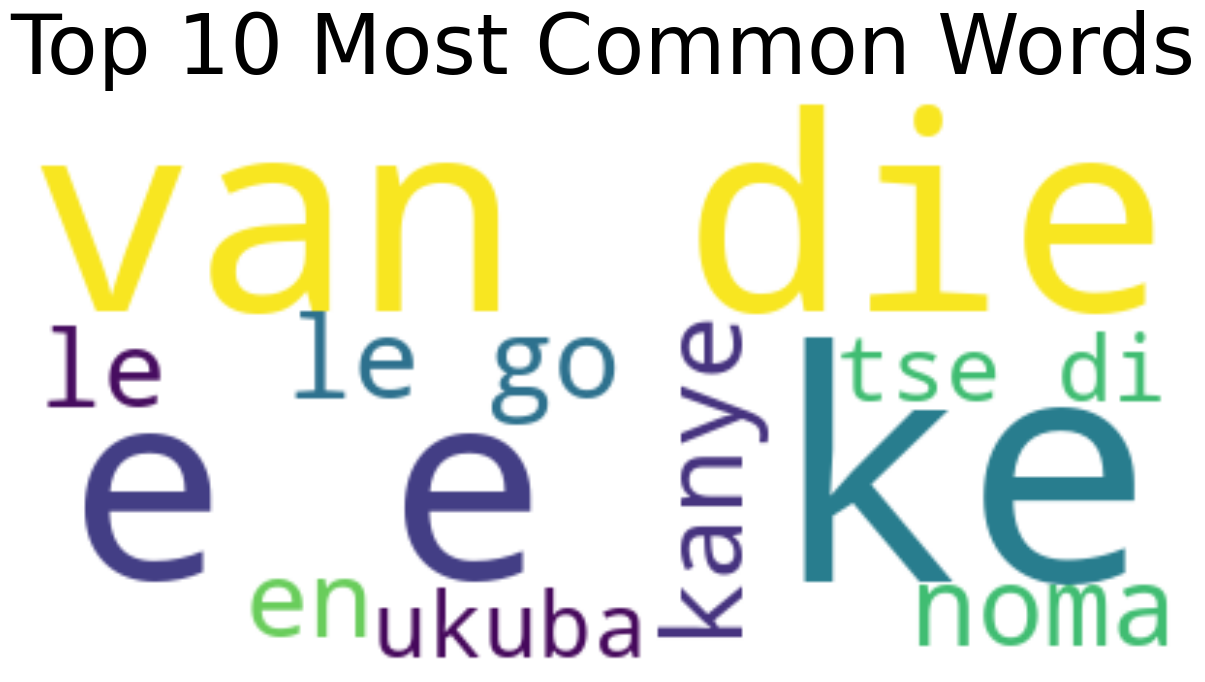

In [14]:
words = ' '.join([text for text in df_train['text']])
wordcloud = WordCloud(width=400,  height=200, random_state=21, max_font_size=110,
                      max_words=10, background_color='white').generate(words)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.title('Top 10 Most Common Words', fontsize=60)
plt.savefig("10commonwordsrawdata.png")
plt.show()

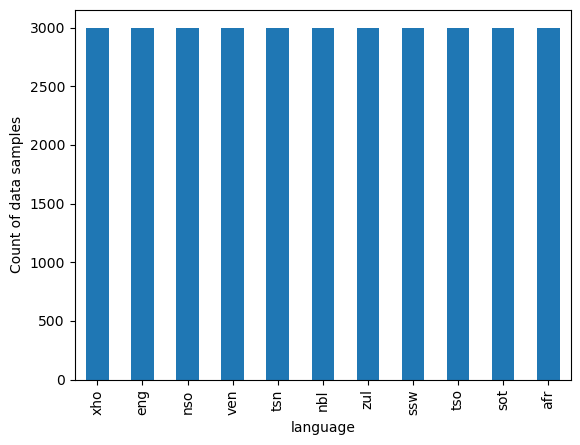

In [15]:
df_train['lang_id'].value_counts().plot(kind = 'bar')
plt.xlabel('language')
plt.ylabel("Count of data samples")
plt.show()

### Data Engenering

In [16]:
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath ...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zoku...
2,eng,the province of kwazulu-natal department of transport invites tenders from established...
3,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a ...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinga...


In [17]:
## Remove urls
print ('Removing URLs...')
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_train['text'] = df_train['text'].replace(to_replace = pattern_url, value = subs_url, regex = True)

# Make lower case
print ('Lowering case...')
df_train['text'] = df_train['text'].str.lower()

# Remove punctuation
import string
print ('Cleaning punctuation...')
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])
df_train['text'] = df_train['text'].apply(remove_punctuation_numbers)

print('Removing duplicates...')
df_train.drop_duplicates(inplace=True)

Removing URLs...
Lowering case...
Cleaning punctuation...
Removing duplicates...


In [18]:
#Checking for any duplicated values
df_train.duplicated().sum()

0

In [19]:
df_train.lang_id.value_counts()

eng    2996
zul    2924
nso    2873
tsn    2869
sot    2829
tso    2757
xho    2658
afr    2640
ven    2605
ssw    2424
nbl    2362
Name: lang_id, dtype: int64

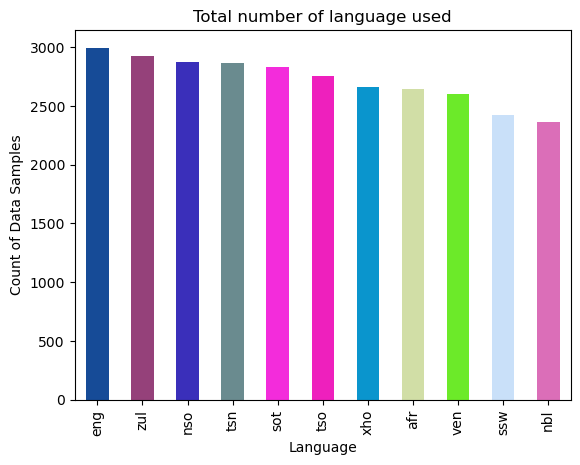

In [20]:
# Generate some random colors for each category
num_categories = len(df_train['lang_id'].unique())
bar_colors = np.random.rand(num_categories, 3)  # RGB values

# Plot the bar graph with custom colors
df_train['lang_id'].value_counts().plot(kind='bar', color=bar_colors)
plt.xlabel('Language')
plt.ylabel('Count of Data Samples')
plt.title('Total number of language used')
plt.show()

In [21]:
# Create a new column 'token' to store the list of tokens for each message.
tokeniser = TreebankWordTokenizer()
df_train['token'] = df_train['text'].apply(tokeniser.tokenize)
df_train.head()

,lang_id,text,token
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath i...,"[umgaqosiseko, wenza, amalungiselelo, kumaziko, axhasa, ulawulo, lwesininzi, kunye, no..."
1,xho,idha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokus...,"[idha, iya, kuba, nobulumko, bokubeka, umsebenzi, naphi, na, kwisebe, ngokusekwe, kwii..."
2,eng,the province of kwazulunatal department of transport invites tenders from established ...,"[the, province, of, kwazulunatal, department, of, transport, invites, tenders, from, e..."
3,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a ...,"[o, netefatša, gore, o, ba, file, dilo, ka, moka, tše, le, dumelelanego, ka, tšona, mo..."
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinga...,"[khomishini, ya, ndinganyiso, ya, mbeu, yo, ewa, maana, u, ya, nga, mulayo, wa, khomis..."


In [22]:
# Creating 'lemmatization' column to store the lemmatized version of each list of tokens
lemmatizer = WordNetLemmatizer()

def df_train_lemmatization(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]

df_train['lemmatization'] = df_train['token'].apply(df_train_lemmatization, args=(lemmatizer, ))

df_train.head()

,lang_id,text,token,lemmatization
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath i...,"[umgaqosiseko, wenza, amalungiselelo, kumaziko, axhasa, ulawulo, lwesininzi, kunye, no...","[umgaqosiseko, wenza, amalungiselelo, kumaziko, axhasa, ulawulo, lwesininzi, kunye, no..."
1,xho,idha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokus...,"[idha, iya, kuba, nobulumko, bokubeka, umsebenzi, naphi, na, kwisebe, ngokusekwe, kwii...","[idha, iya, kuba, nobulumko, bokubeka, umsebenzi, naphi, na, kwisebe, ngokusekwe, kwii..."
2,eng,the province of kwazulunatal department of transport invites tenders from established ...,"[the, province, of, kwazulunatal, department, of, transport, invites, tenders, from, e...","[the, province, of, kwazulunatal, department, of, transport, invite, tender, from, est..."
3,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a ...,"[o, netefatša, gore, o, ba, file, dilo, ka, moka, tše, le, dumelelanego, ka, tšona, mo...","[o, netefatša, gore, o, ba, file, dilo, ka, moka, tše, le, dumelelanego, ka, tšona, mo..."
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinga...,"[khomishini, ya, ndinganyiso, ya, mbeu, yo, ewa, maana, u, ya, nga, mulayo, wa, khomis...","[khomishini, ya, ndinganyiso, ya, mbeu, yo, ewa, maana, u, ya, nga, mulayo, wa, khomis..."


In [23]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
# remove English stop words
vect = CountVectorizer(stop_words='english')

In [25]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))

In [26]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

In [27]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)

In [28]:
betterVect = CountVectorizer(stop_words='english', 
                             min_df=2, 
                             max_df=0.5, 
                             ngram_range=(1, 1))

In [29]:
betterVect.fit([' '.join(doc) for doc in df_train['lemmatization']])

CountVectorizer(max_df=0.5, min_df=2, stop_words='english')

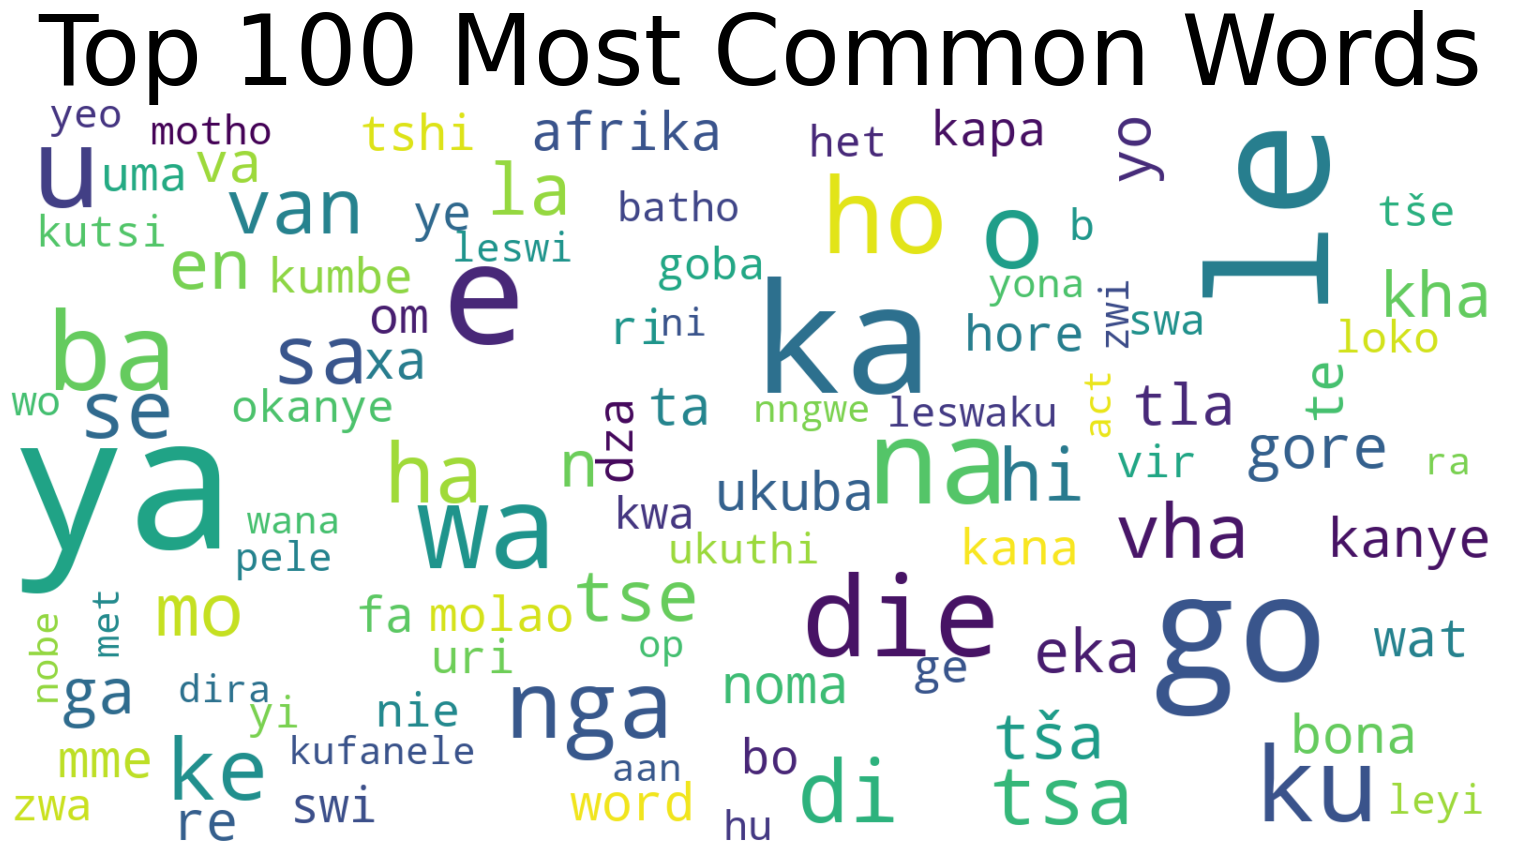

In [30]:
# Assuming 'lemmatization' column contains lists of strings
df_worder = pd.Series(df_train['lemmatization'].apply(lambda x: ' '.join(x))).str.cat(sep=' ')

wordcloud = WordCloud(width=1600,height=800,max_font_size=200,max_words=100,
                       collocations = False, background_color = 'white').generate(df_worder)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Top 100 Most Common Words', fontsize=70)
plt.tight_layout(pad=0)
plt.savefig("Top100commonWords.png")
plt.show()

### Data Modelling

In [31]:
# Feature and target variables
X = df_train['text']
y = df_train['lang_id']

In [32]:
# Vectorize the text data
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X)

In [33]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

### Building Models

In [47]:
# Create a pipeline with TF-IDF vectorizer and Multinomial Naive Bayes classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Define hyperparameters to search
parameters = {
    'tfidf__max_features': [None, 1000, 5000],  # Adjust as needed
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Adjust as needed
    'nb__alpha': [0.1, 1.0, 10.0]  # Adjust as needed
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the validation set
predictions = best_model.predict(X_val)

# Evaluate the F1 score
f1 = f1_score(y_val, predictions, average='weighted')

# Print the best hyperparameters and the F1 score
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Best Naive Bayes F1 Score: {f1}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'nb__alpha': 0.1, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 1)}
Best Naive Bayes F1 Score: 0.9991647907443386


In [48]:
# Now, for testing on a new dataset (assuming df_test is your testing DataFrame)
X_test = df_test['text'].values
test_predictions = model.predict(X_test)

In [49]:
# Creating a submission dataframe with 'index' and 'lang_id' columns
submission_df = pd.DataFrame({'index': df_test['index'], 'lang_id': test_predictions})

submission_df.to_csv('FinalSubmission.csv', index=False)

In [50]:
submission_df

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot
